In [1]:
%load_ext autoreload
%autoreload 2
from data_util import *
from metric_util import *
from train_util import *
from model import *

import torch 
import pickle
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.models import resnet18
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.path.append('./PyGCL')
import GCL.losses as L
from GCL.models import DualBranchContrast
from GCL.eval import get_split, LREvaluator


In [9]:
config = {
    # meta config
    'dataset_name': 'celeba',
    'sens_name': 'gender',
    'conditional': False,
    'debias': False,
    'adversarial': False,
    # tunable config
    'batch_size': 256 * 2,
    'hidden_dim': 240,
    'drop_prob': 0.2,
    'cond_temp': 1.0/200,
    'debias_temp': 1.0/30,
    'debias_ratio': 4,
    'lr': 0.00005,
    'tau': 0.1,
}

In [10]:
# some more config setting
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

dataset_name = config['dataset_name']
sens_name = config['sens_name']
sens_num = 2 if sens_name=='gender' else 1
TASK_TYPE = 'regression' if dataset_name=='crimes' else 'classification'

In [11]:
# load dataset...
dataset = get_dataset(dataset_name, sens_name)
#x = dataset[:][0]
#sens = dataset[:][2]
x, sens = get_samples(dataset, num=1000)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)

In [12]:
# prepare model config
#input_dim = dataset[0][0].shape[-1]
hidden_dim = config['hidden_dim'] if config['dataset_name'] != 'celeba' else 1000
sens_dim = dataset.sens_dim

In [13]:
# create model
main_encoder = RES()
sens_encoder = MLP(sens_dim,hidden_dim)
adv_model = Adv_sens(sens_num=sens_num, hidden_dim=hidden_dim)

aug = transforms.Compose([transforms.RandomCrop(size=RESIZE), transforms.ColorJitter(),
                         transforms.Grayscale(num_output_channels=3), transforms.RandomHorizontalFlip(),
                         transforms.RandomVerticalFlip()])#FeatureDrop(drop_prob=config['drop_prob'])

encoder_model = Encoder(main_encoder = main_encoder, augmentor = aug, sens_encoder = sens_encoder, adv_model=adv_model)
encoder_model = encoder_model.to(device)

In [14]:
contrast_model = DualBranchContrast(loss=L.FairInfoNCE(tau=config['tau']), mode='G2G').to(device)
optim = Adam(encoder_model.parameters(), lr=config['lr'])

performance_list = []
hist_gdp_list = []
max_gdp_list = []
kernel_gdp_list = []

epoch = 100
with tqdm(total=epoch, desc='(T)') as pbar:
    for epoch in range(1, epoch+1):
        encoder_model = encoder_model.to(device)
        loss_result = train(encoder_model = encoder_model, contrast_model=contrast_model,
                                         dataloader=dataloader, optimizer = optim,
                                         conditional=config['conditional'],debias=config['debias'], adversarial=config['adversarial'] if epoch%5==0 else False,
                                         cond_temp = config['cond_temp'],
                                         debias_temp = config['debias_temp'],
                                         debias_ratio = config['debias_ratio'])
        pbar.set_postfix({'loss': loss_result['loss'], 
                          'conditional_loss':loss_result['conditional_loss'], 
                          'debias_loss': loss_result['debias_loss'],
                          'adv_loss': loss_result['adv_loss']})
        pbar.update()
        
        if epoch % 1 == 0:
            print(loss_result)
            result, evaluator = test(encoder_model, dataloader, evaluator=LREvaluator(task=TASK_TYPE))
            classifier = result['classifier']
            
            # performance 
            performance = result['mae'] if dataset_name=='crimes' else result['auc']
            print('performance: ', performance)
            performance_list.append(performance)

            # fairness
            hist_gdp = gdp(mode='hist', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('hist gdp: ', hist_gdp)
            hist_gdp_list.append(hist_gdp)
            max_gdp = gdp(mode='max', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('max gdp: ', max_gdp)
            max_gdp_list.append(max_gdp)
            kernel_gdp = gdp(mode='kernel', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('kernel gdp: ', kernel_gdp)
            kernel_gdp_list.append(kernel_gdp)
            #print(' auc: ', result['auc'], ' dp: ', dp)
        

(T):   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# F F F
contrast_model = DualBranchContrast(loss=L.FairInfoNCE(tau=config['tau']), mode='G2G').to(device)
optim = Adam(encoder_model.parameters(), lr=config['lr'])

performance_list = []
hist_gdp_list = []
max_gdp_list = []
kernel_gdp_list = []

epoch = 100
with tqdm(total=epoch, desc='(T)') as pbar:
    for epoch in range(1, epoch+1):
        encoder_model = encoder_model.to(device)
        loss_result = train(encoder_model = encoder_model, contrast_model=contrast_model,
                                         dataloader=dataloader, optimizer = optim,
                                         conditional=config['conditional'],debias=config['debias'], adversarial=config['adversarial'] if epoch%5==0 else False,
                                         cond_temp = config['cond_temp'],
                                         debias_temp = config['debias_temp'],
                                         debias_ratio = config['debias_ratio'])
        pbar.set_postfix({'loss': loss_result['loss'], 
                          'conditional_loss':loss_result['conditional_loss'], 
                          'debias_loss': loss_result['debias_loss'],
                          'adv_loss': loss_result['adv_loss']})
        pbar.update()
        
        if epoch % 1 == 0:
            print(loss_result)
            result, evaluator = test(encoder_model, dataloader, evaluator=LREvaluator(task=TASK_TYPE))
            classifier = result['classifier']
            
            # performance 
            performance = result['mae'] if dataset_name=='crimes' else result['auc']
            print('performance: ', performance)
            performance_list.append(performance)

            # fairness
            hist_gdp = gdp(mode='hist', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('hist gdp: ', hist_gdp)
            hist_gdp_list.append(hist_gdp)
            max_gdp = gdp(mode='max', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('max gdp: ', max_gdp)
            max_gdp_list.append(max_gdp)
            kernel_gdp = gdp(mode='kernel', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('kernel gdp: ', kernel_gdp)
            kernel_gdp_list.append(kernel_gdp)
            #print(' auc: ', result['auc'], ' dp: ', dp)

(T):   1%|          | 1/100 [03:00<4:57:30, 180.31s/it, loss=0.642, conditional_loss=0.642, debias_loss=0, adv_loss=0]

{'loss': 0.6419667425044115, 'conditional_loss': 0.6419667425044115, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.731, F1Ma=0.643]


performance:  0.6345626258763142
hist gdp:  0.09972800000000001
max gdp:  0.2055365946150929
kernel gdp:  0.087692186


(T):   2%|▏         | 2/100 [06:54<5:46:41, 212.26s/it, loss=0.0736, conditional_loss=0.0736, debias_loss=0, adv_loss=0]

{'loss': 0.07356313332540435, 'conditional_loss': 0.07356313332540435, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.725, F1Ma=0.631]


performance:  0.6238862334309304
hist gdp:  0.102008
max gdp:  0.2102356102949663
kernel gdp:  0.089697026


(T):   3%|▎         | 3/100 [10:50<6:00:29, 222.98s/it, loss=0.0544, conditional_loss=0.0544, debias_loss=0, adv_loss=0]

{'loss': 0.054353300259454444, 'conditional_loss': 0.054353300259454444, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.725, F1Ma=0.63]


performance:  0.6231381176116194
hist gdp:  0.09635200000000001
max gdp:  0.19857875385401727
kernel gdp:  0.08472363


(T):   4%|▍         | 4/100 [14:44<6:03:46, 227.36s/it, loss=0.0478, conditional_loss=0.0478, debias_loss=0, adv_loss=0]

{'loss': 0.047750510638521156, 'conditional_loss': 0.047750510638521156, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.726, F1Ma=0.635]


performance:  0.6270269867205733
hist gdp:  0.10283600000000001
max gdp:  0.21194209493660449
kernel gdp:  0.0904251


(T):   5%|▌         | 5/100 [18:39<6:04:00, 229.90s/it, loss=0.0429, conditional_loss=0.0429, debias_loss=0, adv_loss=0]

{'loss': 0.042856269240754204, 'conditional_loss': 0.042856269240754204, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.73, F1Ma=0.637]


performance:  0.6292773642022135
hist gdp:  0.10946000000000002
max gdp:  0.22559397206971032
kernel gdp:  0.09624967


(T):   6%|▌         | 6/100 [22:33<6:02:34, 231.44s/it, loss=0.0401, conditional_loss=0.0401, debias_loss=0, adv_loss=0]

{'loss': 0.04007712656151761, 'conditional_loss': 0.04007712656151761, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.72, F1Ma=0.628]


performance:  0.6216384521635266
hist gdp:  0.10911600000000002
max gdp:  0.22488499777415044
kernel gdp:  0.09594718


(T):   7%|▋         | 7/100 [26:27<6:00:13, 232.41s/it, loss=0.0378, conditional_loss=0.0378, debias_loss=0, adv_loss=0]

{'loss': 0.03775195900421097, 'conditional_loss': 0.03775195900421097, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.72, F1Ma=0.626]


performance:  0.6199792751238548
hist gdp:  0.10780400000000002
max gdp:  0.22218100278643388
kernel gdp:  0.09479352


(T):   8%|▊         | 8/100 [30:22<5:57:23, 233.08s/it, loss=0.0362, conditional_loss=0.0362, debias_loss=0, adv_loss=0]

{'loss': 0.03617247288355475, 'conditional_loss': 0.03617247288355475, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.721, F1Ma=0.626]


performance:  0.6199317599780478
hist gdp:  0.10318
max gdp:  0.21265106923216437
kernel gdp:  0.090727575


(T):   9%|▉         | 9/100 [34:16<5:54:06, 233.48s/it, loss=0.0352, conditional_loss=0.0352, debias_loss=0, adv_loss=0]

{'loss': 0.03521631581931369, 'conditional_loss': 0.03521631581931369, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.726, F1Ma=0.633]


performance:  0.6260286716383043
hist gdp:  0.097244
max gdp:  0.2004171406901782
kernel gdp:  0.085507974


(T):  10%|█         | 10/100 [38:11<5:50:43, 233.81s/it, loss=0.0344, conditional_loss=0.0344, debias_loss=0, adv_loss=0]

{'loss': 0.03437289359551743, 'conditional_loss': 0.03437289359551743, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.724, F1Ma=0.629]


performance:  0.6224505002236373
hist gdp:  0.103524
max gdp:  0.21336004352772417
kernel gdp:  0.09103006


(T):  11%|█         | 11/100 [42:06<5:47:16, 234.12s/it, loss=0.0332, conditional_loss=0.0332, debias_loss=0, adv_loss=0]

{'loss': 0.03317140449283633, 'conditional_loss': 0.03317140449283633, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.723, F1Ma=0.63]


performance:  0.6232843476311217
hist gdp:  0.100556
max gdp:  0.20724307925673116
kernel gdp:  0.08842026


(T):  12%|█▏        | 12/100 [46:00<5:43:34, 234.25s/it, loss=0.0326, conditional_loss=0.0326, debias_loss=0, adv_loss=0]

{'loss': 0.032616274407918346, 'conditional_loss': 0.032616274407918346, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.719, F1Ma=0.621]


performance:  0.6160576490216115
hist gdp:  0.098416
max gdp:  0.20283259962737626
kernel gdp:  0.08653853


(T):  13%|█▎        | 13/100 [49:55<5:39:56, 234.44s/it, loss=0.032, conditional_loss=0.032, debias_loss=0, adv_loss=0]  

{'loss': 0.032023709454813844, 'conditional_loss': 0.032023709454813844, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.72, F1Ma=0.631]


performance:  0.6244641794653158
hist gdp:  0.102072
max gdp:  0.21036751248948904
kernel gdp:  0.0897533


(T):  14%|█▍        | 14/100 [53:50<5:36:00, 234.42s/it, loss=0.0314, conditional_loss=0.0314, debias_loss=0, adv_loss=0]

{'loss': 0.031432784426043615, 'conditional_loss': 0.031432784426043615, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.722, F1Ma=0.627]


performance:  0.6201128149864011
hist gdp:  0.099244
max gdp:  0.20453908426901452
kernel gdp:  0.0872666


(T):  15%|█▌        | 15/100 [57:45<5:32:33, 234.74s/it, loss=0.0309, conditional_loss=0.0309, debias_loss=0, adv_loss=0]

{'loss': 0.030886147305978544, 'conditional_loss': 0.030886147305978544, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.725, F1Ma=0.636]


performance:  0.6289900008124942
hist gdp:  0.10986800000000001
max gdp:  0.2264348485597929
kernel gdp:  0.09660842


(T):  16%|█▌        | 16/100 [1:01:40<5:28:33, 234.68s/it, loss=0.0305, conditional_loss=0.0305, debias_loss=0, adv_loss=0]

{'loss': 0.030499808267696098, 'conditional_loss': 0.030499808267696098, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.727, F1Ma=0.631]


performance:  0.623555266749205
hist gdp:  0.103932
max gdp:  0.2142009200178068
kernel gdp:  0.09138882


(T):  17%|█▋        | 17/100 [1:05:34<5:24:38, 234.68s/it, loss=0.0302, conditional_loss=0.0302, debias_loss=0, adv_loss=0]

{'loss': 0.030191128101176436, 'conditional_loss': 0.030191128101176436, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.719, F1Ma=0.625]


performance:  0.6193855314566479
hist gdp:  0.10904
max gdp:  0.2247283639181547
kernel gdp:  0.09588035


(T):  18%|█▊        | 18/100 [1:09:29<5:20:48, 234.74s/it, loss=0.0299, conditional_loss=0.0299, debias_loss=0, adv_loss=0]

{'loss': 0.02990869219479321, 'conditional_loss': 0.02990869219479321, 'debias_loss': 0.0, 'adv_loss': 0.0}


(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.723, F1Ma=0.624]


performance:  0.6182473169254863
hist gdp:  0.09944799999999998
max gdp:  0.20495952251405583
kernel gdp:  0.087445974


In [2]:
load_pokec

<function data_util.load_pokec(dataset, sens_attr, predict_attr, path='../dataset/pokec/', sens_number=500, seed=19, test_idx=False)>

In [42]:
dataset = 'region_job'
sens_attr = 'region' # AGE
predict_attr = 'I_am_working_in_field'#'spoken_languages_indicator'
path="./datasets/pokec/"
sens_number=500
seed=19
test_idx=False
import scipy.sparse as sp
print('Loading {} dataset from {}'.format(dataset,path))

idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
header = list(idx_features_labels.columns)
header.remove("user_id")

header.remove(sens_attr)
header.remove(predict_attr)


features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
labels = idx_features_labels[predict_attr].values


# build graph
idx = np.array(idx_features_labels["user_id"], dtype=int)
idx_map = {j: i for i, j in enumerate(idx)}
edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)

edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                    dtype=int).reshape(edges_unordered.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

# features = normalize(features)
adj = adj + sp.eye(adj.shape[0])

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(labels)
# adj = sparse_mx_to_torch_sparse_tensor(adj)

import random
random.seed(seed)
label_idx = np.where(labels>=0)[0]
random.shuffle(label_idx)

idx_train = label_idx[:int(0.5 * len(label_idx))]
idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
if test_idx:
    idx_test = label_idx[int(0.5 * len(label_idx)):]
    idx_val = idx_test
else:
    idx_test = label_idx[int(0.75 * len(label_idx)):]

sens = idx_features_labels[sens_attr].values

sens_idx = set(np.where(sens >= 0)[0])
idx_test = np.asarray(list(sens_idx & set(idx_test)))
sens = torch.FloatTensor(sens)
idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
random.seed(seed)
random.shuffle(idx_sens_train)
idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])


idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

Loading region_job dataset from ./datasets/pokec/


In [45]:
sens.shape

torch.Size([67796])

(array([43962.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 23834.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

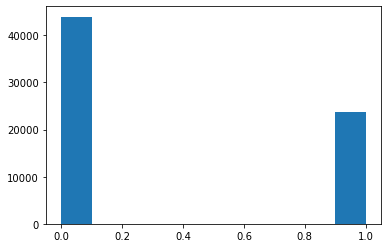

In [40]:
from matplotlib import pyplot as plt
plt.hist(sens.numpy())

In [41]:
import dgl
from utils import feature_norm
# g = dgl.DGLGraph()
g = dgl.from_scipy(adj)
g = g.to(device)

ModuleNotFoundError: No module named 'dgl'

In [28]:
label_idx?

Type:        ndarray
String form: [15836 41916  8624 ... 67042 15818  5669]
Length:      67796
File:        /data/qf31/anaconda3/envs/graph/lib/python3.9/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes below)

shape : tuple of ints
    Shape of created a

In [9]:
labels?

Type:        Tensor
String form: tensor([1, 1, 1,  ..., 0, 0, 0])
Length:      67796
File:        /data/qf31/anaconda3/envs/graph/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


In [14]:
idx?

Type:        ndarray
String form: [      1  131075       5 ... 1572853 1572859  393212]
Length:      67796
File:        /data/qf31/anaconda3/envs/graph/lib/python3.9/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes below)

shape : tuple of ints
    Shape 